## ARMA Modeling: Forecasting

**Functions**

`tsa.SARIMAX.forecast`

### Exercise 70
Produce 1-step forecasts from your preferred model in the previous exercise, as well
as a random-walk model. 

1. Are the forecasts objectively accurate?
2. Compare these forecasts to the random walk models using MSE and MAE.

**Note**: Use 50% of the sample to estimate the model and 50% to evaluate it.

### Loading the Data

We will continue to study the **term_premium** dataset. We will again focus on the **term** series.

Before we load the data, we need to check where our current directory is. To check/change our current directory, we use **os**:

In [2]:
import os
os.getcwd()

'/Users/talespadilha/Documents/Oxford/Teaching/Financial Econometrics/20-21/python/python_course/time_series'

In [3]:
os.chdir('/Users/talespadilha/Documents/Oxford/Teaching/Financial Econometrics/20-21/python/python-introduction/course/autumn')
os.getcwd() 

'/Users/talespadilha/Documents/Oxford/Teaching/Financial Econometrics/20-21/python/python-introduction/course/autumn'

In [4]:
import pandas as pd

In [5]:
data = pd.read_hdf("data/term-premium.h5", "term_premium")
term = data["TERM"]
term.head()

DATE
1953-04-01    0.47
1953-05-01    0.57
1953-06-01    0.66
1953-07-01    0.55
1953-08-01    0.67
Freq: MS, Name: TERM, dtype: float64

### Fitting the Model with the First Half

In [6]:
import statsmodels.tsa.api as tsa

In [7]:
nobs = term.shape[0]
half = nobs // 2
mod = tsa.SARIMAX(term.iloc[:half], order=(1, 0, 1), trend="c")
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   TERM   No. Observations:                  406
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 -73.462
Date:                Wed, 17 Feb 2021   AIC                            154.924
Time:                        15:32:03   BIC                            170.949
Sample:                    04-01-1953   HQIC                           161.266
                         - 01-01-1987                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0569      0.022      2.588      0.010       0.014       0.100
ar.L1          0.8944      0.017     53.797      0.000       0.862       0.927
ma.L1          0.4603      0.020     22.922      0.000       0.421       0.500
sigma2         0.0836      0.003     26.705      0.000       0.077       0.090
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):               933.37
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               6.70   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Using the Estimated Parameters to Forecast

We are now going to use the parameters estimated using the first half of the dataset to forecast. In order to do this, we will use the **tsa.statespace.SARIMAX** rather than the **tsa.SARIMAX**.

In [8]:
# Setting the model
mod = tsa.statespace.SARIMAX(term, order=(1,0,1), trend="c")

In [9]:
# Using the parameters from the first half
forecast_res = mod.filter(res.params)

In [10]:
# Forecasting with the model
fcast = forecast_res.predict()

In [11]:
# Saving the erros
errors = term - fcast
errors_oos = errors.iloc[half:]

### Plotting the Residuals

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

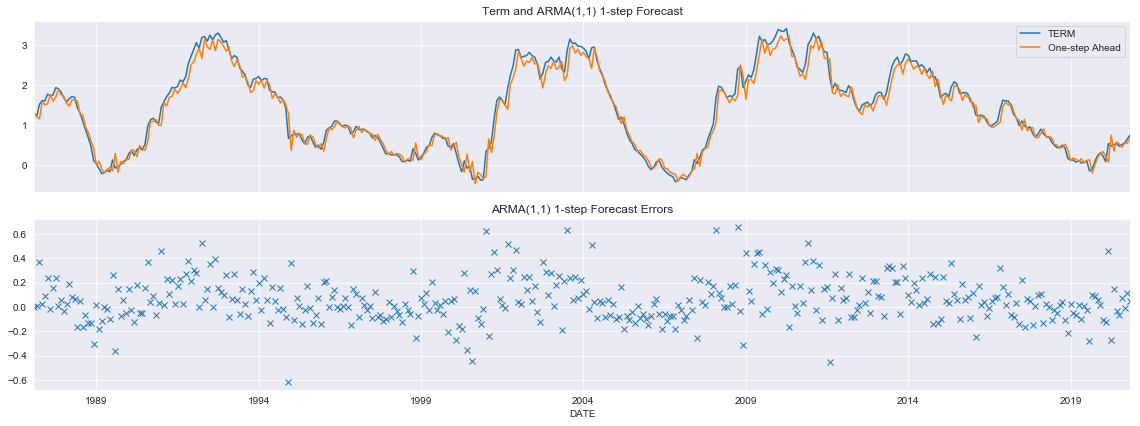

In [13]:
# Setting what we will plot
both = pd.concat([term, fcast],1)
both.columns = ["TERM", "One-step Ahead"]
both_oos = both.iloc[half:]
# Building the plot (full sample)
sns.set_style("darkgrid")
plt.rc("figure", figsize=(16,6))
fig, axes = plt.subplots(2,1)
both_oos.plot.line(ax=axes[0])
axes[0].set_xticklabels([])
axes[0].set_xlabel("")
axes[0].set_title("Term and ARMA(1,1) 1-step Forecast")
errors_oos.plot.line(ax=axes[1], linestyle="none", marker="x")
axes[1].set_title("ARMA(1,1) 1-step Forecast Errors")
fig.tight_layout(pad=1.0)

### Forecast Accuracy

We will use the Mincer-Zarnowitz framework to evaluate the accuracy of our forecasts. 

Let's first recall the idea Mincer-Zarnowitz framework. Let $\{y_{t+1}\}$ be a time series process and $\{\hat{y}_{t+1|t}\}$ a model forecast of this process. Consider the following:

$     y_{t+1} =  \alpha + \beta \hat{y}_{t+1|t} + \mu_{t+1} $

If $\{\hat{y}_{t+1|t}\}$ is a good forecast, what values should we expect for $\alpha$ and $\beta$? 

- $\alpha = 0$
- $\beta = 1$

But notice that if we write:

$ y_{t+1} - \hat{y}_{t+1|t} =  \gamma_0 + \gamma_1 \hat{y}_{t+1|t} + \mu_{t+1} $

$ \epsilon_{t+1}  =  \gamma_0 + \gamma_1 \hat{y}_{t+1|t} + \mu_{t+1} $

The analysis is simplified and we can test if $\hat{y}_{t+1|t}$ is a good forecast simply by testing:

- $ H_0: \gamma_0 = \gamma_1 = 0 $

And this is precisely what we are going to test. 

In [14]:
import numpy as np
import statsmodels.api as sm

In [15]:
# Fitting the MZ Regression
mz_reg = sm.add_constant(fcast.iloc[half:])
mz_reg.columns = ["Const", "Forecast"]
res = sm.OLS(errors_oos, mz_reg).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     44.32
Date:                Wed, 17 Feb 2021   Prob (F-statistic):           9.13e-11
Time:                        15:32:09   Log-Likelihood:                 148.41
No. Observations:                 406   AIC:                            -292.8
Df Residuals:                     404   BIC:                            -284.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Const         -0.0158      0.014     -1.107      0.269      -0.044       0.012
Forecast       0.0575      0.009      6.657      0.000       0.041       0.075
==============================================================================
Omnibus:                       27.934   Durbin-Watson:                   2.270
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.025
Skew:                           0.369   Prob(JB):                     9.24e-14
Kurtosis:                       4.733   Cond. No.                         3.57
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now formally testing the $H_0$ from the MZ test:

In [16]:
# MZ test
r_matrix = np.eye(2)
res.wald_test(r_matrix)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[48.91280304]]), p=9.492192943713441e-20, df_denom=404, df_num=2>

In [22]:
r_matrix

array([[1., 0.],
       [0., 1.]])

### Random Walk Model

In [16]:
# Constructing the RW forecasts
rw_forecast = term.shift(1)

In [17]:
# Fitting the MZ Regression
both = pd.concat([term, rw_forecast],1)
rw_error = term - rw_forecast
rw_oos_error = rw_error.iloc[half:]
rw_forecast = sm.add_constant(rw_forecast)
rw_forecast = rw_forecast.iloc[half:]
rw_forecast.columns = ["Const", "One-step RW Forecast"]
res = sm.OLS(rw_oos_error, rw_forecast).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   TERM   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.719
Date:                Sun, 10 Jan 2021   Prob (F-statistic):             0.0999
Time:                        19:38:27   Log-Likelihood:                 132.82
No. Observations:                 406   AIC:                            -261.6
Df Residuals:                     404   BIC:                            -253.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Const                    0.0180      0.015      1.232      0.218      -0.011       0.047
One-step RW Forecast    -0.0138      0.008     -1.649      0.100      -0.030       0.003
==============================================================================
Omnibus:                       40.917   Durbin-Watson:                   1.429
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              105.791
Skew:                           0.486   Prob(JB):                     1.07e-23
Kurtosis:                       5.304   Cond. No.                         3.61
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
# MZ test
res.wald_test(r_matrix)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[48.91280304]]), p=9.492192943713441e-20, df_denom=404, df_num=2>

It looks like, overall, the RW one step ahead forecasts are more accurate than our ARMA(1,1) forecasts according to the MZ framework :(

### Calculating MSE and MAE

In [19]:
errors = pd.DataFrame({"ARMA": errors_oos, "RW": rw_oos_error}).dropna()
pd.DataFrame([(errors ** 2).mean(), errors.abs().mean()], index=['MSE', 'MAE'])

,ARMA,RW
MSE,0.035010,0.030642
MAE,0.138425,0.129039


The better performance of the RW model is further confirmed by looking at the MSE and MAE from both models :(

### Exercise 71

Produce 3-step forecasts from the models selected in the previous exercises as well as a random walk model.

1. Compare these forecasts to the random walk models using MSE and MAE.


### Fitting the Model with the First Half

In [20]:
mod = tsa.SARIMAX(term.iloc[:half], order=(1, 0, 1), trend="c")
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   TERM   No. Observations:                  406
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 -73.462
Date:                Sun, 10 Jan 2021   AIC                            154.924
Time:                        19:38:31   BIC                            170.949
Sample:                    04-01-1953   HQIC                           161.266
                         - 01-01-1987                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0569      0.022      2.588      0.010       0.014       0.100
ar.L1          0.8944      0.017     53.797      0.000       0.862       0.927
ma.L1          0.4603      0.020     22.922      0.000       0.421       0.500
sigma2         0.0836      0.003     26.705      0.000       0.077       0.090
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):               933.37
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               6.70   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Using the Estimated Parameters to Forecast

In [21]:
mod = tsa.statespace.SARIMAX(term, order=(1,0,1), trend="c")
forecast_res = mod.filter(res.params)

In [22]:
# Constructing the 3-steps ahead forecasts
three_step = {}
for t in range(half, nobs):
    fcasts = forecast_res.predict(t, t+2, dynamic=True)
    key = fcasts.index[-1]
    value = fcasts.iloc[-1]
    three_step[key] = value
three_step = pd.Series(three_step)

In [23]:
three_step_errors = term - three_step
three_step_errors = three_step_errors.dropna()
three_step_errors

1987-04-01    0.377268
1987-05-01    0.534908
1987-06-01    0.569635
1987-07-01    0.393922
1987-08-01    0.415522
                ...   
2020-07-01    0.072935
2020-08-01   -0.053012
2020-09-01    0.014630
2020-10-01    0.194002
2020-11-01    0.197881
Length: 404, dtype: float64

### Now Getting the 3-Step Ahead Forecasts for the RW Model

In [24]:
three_step_rw = term.shift(3)
three_step_rw_errors = term - three_step_rw
three_step_rw_errors = three_step_rw_errors.iloc[half:]

### Calculating MSE and MAE

In [25]:
errors = pd.DataFrame({"ARMA": three_step_errors, "RW": three_step_rw_errors}).dropna()
pd.DataFrame([(errors ** 2).mean(), errors.abs().mean()], index=['MSE', 'MAE'])

,ARMA,RW
MSE,0.209583,0.130221
MAE,0.350717,0.276015


The better performance of the RW model persists even with a longer forecasting horizon. If anything, it seems to have a better relative performance in comparison to an ARMA(1,1) :(

### The Diebold-Mariano Test

A formal way to compare forecasts from different models is to perform a Diebold-Mariano Test.

Let $\{\epsilon_t^A\}$ be the series of residuals from Model A and $\{\epsilon_t^B\}$ be the series of residuals from model B.

One can define the difference in a penalty measure such as:

$d_t = (\epsilon_t^A)^2 - (\epsilon_t^B)^2$ or $d_t = |\epsilon_t^A| - |\epsilon_t^B|$

And construct the following regression:

$d_t = \alpha + \mu_t$

One can then formally test for which is the better model by looking at the $\alpha$ estimate (using Heteroskedasticity-and-Autocorrelation-Consistent Standard Errors to consider for the fact that we are dealing with time series). 

- If $\alpha$ is significantly larger than zero: model B performs better than model A;
- If $\alpha$ is significantly larger than zero: model A performs better than model B;
- If $\alpha$ is not significantly different from zero: no model is significantly better.

In [27]:
# MSE DM Test
d = errors["ARMA"] ** 2 - errors["RW"] ** 2
x = np.ones_like(d)
maxlags = int(d.shape[0] ** (1/3))
res = sm.OLS(d, x).fit(cov_type="HAC", cov_kwds={"maxlags": maxlags})
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 10 Jan 2021   Prob (F-statistic):                nan
Time:                        19:38:41   Log-Likelihood:                -18.869
No. Observations:                 404   AIC:                             39.74
Df Residuals:                     403   BIC:                             43.74
Df Model:                           0                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0794      0.026      3.083      0.002       0.029       0.130
==============================================================================
Omnibus:                       88.366   Durbin-Watson:                   0.445
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              213.263
Skew:                           1.085   Prob(JB):                     4.90e-47
Kurtosis:                       5.821   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 7 lags and without small sample correction
"""

In [28]:
# MAE DM Test
d = errors["ARMA"].abs() - errors["RW"].abs()
res = sm.OLS(d, x).fit(cov_type="HAC", cov_kwds={"maxlags": maxlags})
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 10 Jan 2021   Prob (F-statistic):                nan
Time:                        19:38:45   Log-Likelihood:                -47.736
No. Observations:                 404   AIC:                             97.47
Df Residuals:                     403   BIC:                             101.5
Df Model:                           0                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0747      0.027      2.786      0.005       0.022       0.127
==============================================================================
Omnibus:                        0.488   Durbin-Watson:                   0.539
Prob(Omnibus):                  0.783   Jarque-Bera (JB):                0.556
Skew:                           0.080   Prob(JB):                        0.757
Kurtosis:                       2.916   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 7 lags and without small sample correction
"""

The results from the MSE and MAE show that, indeed, the random-walk model performs better than our selected ARMA(1,1) in forecasting. 

The lesson here is: forecasting the first moment (i.e. mean) of time series is very hard :(

But life is not just bad news folks! As we are going to see later on, we are a lot more successful when we model second moments dynamics!

In [23]:
import numpy as np
import pandas as pd
nobs = 100
np.random.seed(987125)
yx = np.random.randn(nobs, 2)
beta0 = 0
beta1 = 1
yx[:, 0] += beta0 + beta1 * yx[:, 1]
data = pd.DataFrame(yx, columns=['TOTEMP', 'GNP'])

hypothesis_0 = '(Intercept = 0, GNP = 0)'
hypothesis_1 = '(GNP = 0)'
hypothesis_2 = '(GNP = 1)'
hypothesis_3 = '(Intercept = 0, GNP = 1)'
results = smf.ols('TOTEMP ~ GNP', data).fit()
wald_0 = results.wald_test(hypothesis_0)
wald_1 = results.wald_test(hypothesis_1)
wald_2 = results.wald_test(hypothesis_2)
wald_3 = results.wald_test(hypothesis_3)

print('H0:', hypothesis_0)
print(wald_0)
print()
print('H0:', hypothesis_1)
print(wald_1)
print()
print('H0:', hypothesis_2)
print(wald_2)
print()
print('H0:', hypothesis_3)
print(wald_3)

NameError: name 'smf' is not defined

In [32]:
res.wald_test(r_matrix).fvalue

array([[48.91280304]])

In [30]:
type(x)

statsmodels.stats.contrast.ContrastResults

array([[48.91280304]])